# Not sure who created this model, but we are using it to match individuals from different MDD subtypes--attempting to detect a difference in HPA axis behavior between them

# Table of Contents
1. [Imports](#imports)
2. [Parameters and Initial Conditions](#params)
3. [Put Raw Data into Arrays](#rawdata)
    1. [Plot Data Sets](#plotdata)
4. [Model Function--Includes ODE Solver](#modelfunction)
5. [Functions to Determine Delayed ACTH and Cortisol Values](#delays)
6. [Cost Function Definition](#cost)
7. [Run the Optimization](#run)
8. [Save Output to File](#saveoutput)
9. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
10. [Plots](#plots)
11. [No Optimization Run and Plot](#no-opt)
11. [Dependencies](#dependencies)

## Imports <a name="imports"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import matplotlib
import pandas as pd
from HPAmodeling import ODEsolver, costFun, dataImport

## Parameters and Initial Conditions <a name="params"></a>

In [2]:
# Initial Conditions (starting with Atypical subgroup, first patient and assuming CRH, GR and StreSig start at 1)
# Order is: CRH, ACTH, COR, GR, StreSig, kStr
y0 = [1, 33.6, 7.4, 1, 0.1, 0]

In [3]:
# These are the only fixed parameters, the rest need to be determined through optimization
sigma = 2
sigma2 = 5

In [26]:
# Parameters to optimize: R0CRH, RCRH_CRH, RSS_CRH, RGR_CRH, tsCRH, R0ACTH, RCRH_ACTH, RGR_ACTH, tsACTH, 
#   R0COR, RACTH_COR, tsCOR, R0GR, RCOR_GR, RGR_GR, tsGR
bounds = [(0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10)]


In [5]:
# Set the time interval over which to integrate, and the size of time steps to use
t_start = -0.01
t_end = 140.01
t_step = 0.01

## Put Raw Data Into Arrays <a name="rawdata"></a>

In [6]:
yehudaControlCortisol, yehudaControlCortisol_smooth, yehudaPTSDCortisol, yehudaPTSDCortisol_smooth, yehudaDepressedCortisol, yehudaDepressedCortisol_smooth = dataImport.yehuda()

In [7]:
carrollControlCortisol, carrollControlCortisol_rearr, carrollControlCortisol_smooth, carrollControlCortisol_rearr_smooth, carrollControlACTH, carrollControlACTH_rearr, carrollControlACTH_smooth, carrollControlACTH_rearr_smooth, carrollHCDepressedCortisol, carrollHCDepressedCortisol_rearr, carrollHCDepressedCortisol_smooth, carrollHCDepressedCortisol_rearr_smooth, carrollHCDepressedACTH, carrollHCDepressedACTH_rearr, carrollHCDepressedACTH_smooth, carrollHCDepressedACTH_rearr_smooth, carrollLCDepressedCortisol, carrollLCDepressedCortisol_rearr, carrollLCDepressedCortisol_smooth, carrollLCDepressedCortisol_rearr_smooth, carrollLCDepressedACTH, carrollLCDepressedACTH_rearr, carrollLCDepressedACTH_smooth, carrollLCDepressedACTH_rearr_smooth = dataImport.carroll()

In [8]:
golierPTSDCortisol, golierPTSDCortisol_rearr, golierPTSDCortisol_smooth, golierPTSDCortisol_rearr_smooth, golierPTSDACTH, golierPTSDACTH_rearr, golierPTSDACTH_smooth, golierPTSDACTH_rearr_smooth, golierNonPTSDTraumaExposedCortisol, golierNonPTSDTraumaExposedCortisol_rearr, golierNonPTSDTraumaExposedCortisol_smooth, golierNonPTSDTraumaExposedCortisol_rearr_smooth, golierNonPTSDTraumaExposedACTH, golierNonPTSDTraumaExposedACTH_rearr, golierNonPTSDTraumaExposedACTH_smooth, golierNonPTSDTraumaExposedACTH_rearr_smooth, golierNonPTSDNonExposedCortisol, golierNonPTSDNonExposedCortisol_rearr, golierNonPTSDNonExposedCortisol_smooth, golierNonPTSDNonExposedCortisol_rearr_smooth, golierNonPTSDNonExposedACTH, golierNonPTSDNonExposedACTH_rearr, golierNonPTSDNonExposedACTH_smooth, golierNonPTSDNonExposedACTH_rearr_smooth = dataImport.golier()

In [9]:
bremnerAbusedPTSDCortisol, bremnerAbusedPTSDCortisol_rearr, bremnerAbusedPTSDCortisol_smooth, bremnerAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedPTSDCortisol, bremnerNonAbusedPTSDCortisol_rearr, bremnerNonAbusedPTSDCortisol_smooth, bremnerNonAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedNonPTSDCortisol, bremnerNonAbusedNonPTSDCortisol_rearr, bremnerNonAbusedNonPTSDCortisol_smooth, bremnerNonAbusedNonPTSDCortisol_rearr_smooth = dataImport.bremner()

In [10]:
nelsonCortisol, nelsonACTH, nelsonAtypicalCORT, nelsonAtypicalACTH, nelsonMelancholicCORT, nelsonMelancholicACTH, nelsonNeitherCORT, nelsonNeitherACTH, nelsonHealthyCORT, nelsonHealthyACTH, atypical_ids, melancholic_ids, neither_ids, healthy_ids = dataImport.nelson()

### Plot Data Sets <a name="plotdata"></a>

In [11]:
# change the time scale of the Golier data sets to minutes (from hours)
for i in range(len(golierPTSDCortisol)):
    golierPTSDCortisol[i,0] = golierPTSDCortisol[i,0]*60
    golierNonPTSDTraumaExposedCortisol[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]*60
    golierNonPTSDNonExposedCortisol[i,0] = golierNonPTSDNonExposedCortisol[i,0]*60
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol_rearr[i,0]*60
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol_rearr[i,0]*60
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol_rearr[i,0]*60
    golierPTSDCortisol_smooth[i,0] = golierPTSDCortisol_smooth[i,0]*60
    golierNonPTSDTraumaExposedCortisol_smooth[i,0] = golierNonPTSDTraumaExposedCortisol_smooth[i,0]*60
    golierNonPTSDNonExposedCortisol_smooth[i,0] = golierNonPTSDNonExposedCortisol_smooth[i,0]*60
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol_rearr_smooth[i,0]*60
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0]*60
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol_rearr_smooth[i,0]*60
    
for i in range(len(golierPTSDACTH)):
    golierPTSDACTH[i,0] = golierPTSDACTH[i,0]*60
    golierNonPTSDTraumaExposedACTH[i,0] = golierNonPTSDTraumaExposedACTH[i,0]*60
    golierNonPTSDNonExposedACTH[i,0] = golierNonPTSDNonExposedACTH[i,0]*60
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH_rearr[i,0]*60
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH_rearr[i,0]*60
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH_rearr[i,0]*60
    golierPTSDACTH_smooth[i,0] = golierPTSDACTH_smooth[i,0]*60
    golierNonPTSDTraumaExposedACTH_smooth[i,0] = golierNonPTSDTraumaExposedACTH_smooth[i,0]*60
    golierNonPTSDNonExposedACTH_smooth[i,0] = golierNonPTSDNonExposedACTH_smooth[i,0]*60
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH_rearr_smooth[i,0]*60
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0]*60
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH_rearr_smooth[i,0]*60

In [12]:
# change the time scale of the Bremner data sets to minutes (from hours)
for i in range(len(bremnerAbusedPTSDCortisol)):
    bremnerAbusedPTSDCortisol[i,0] = bremnerAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedPTSDCortisol[i,0] = bremnerNonAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedNonPTSDCortisol[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]*60
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol_rearr[i,0]*60
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol_rearr[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol_rearr[i,0]*60
    bremnerAbusedPTSDCortisol_smooth[i,0] = bremnerAbusedPTSDCortisol_smooth[i,0]*60
    bremnerNonAbusedPTSDCortisol_smooth[i,0] = bremnerNonAbusedPTSDCortisol_smooth[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol_smooth[i,0]*60
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol_rearr_smooth[i,0]*60
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0]*60
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0]*60

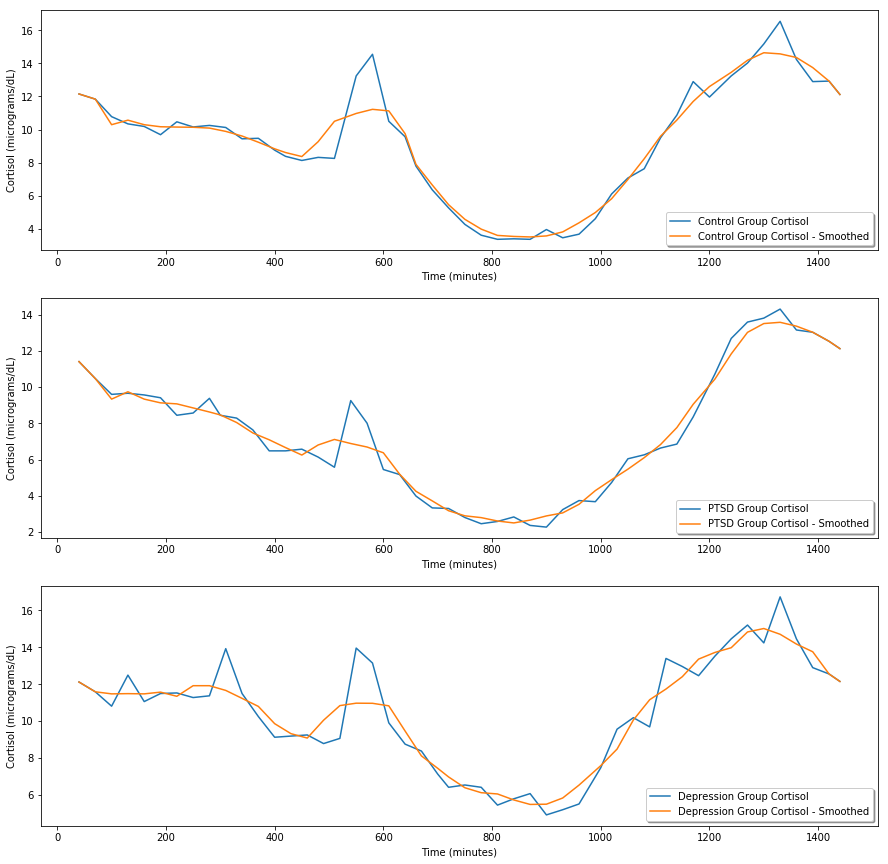

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


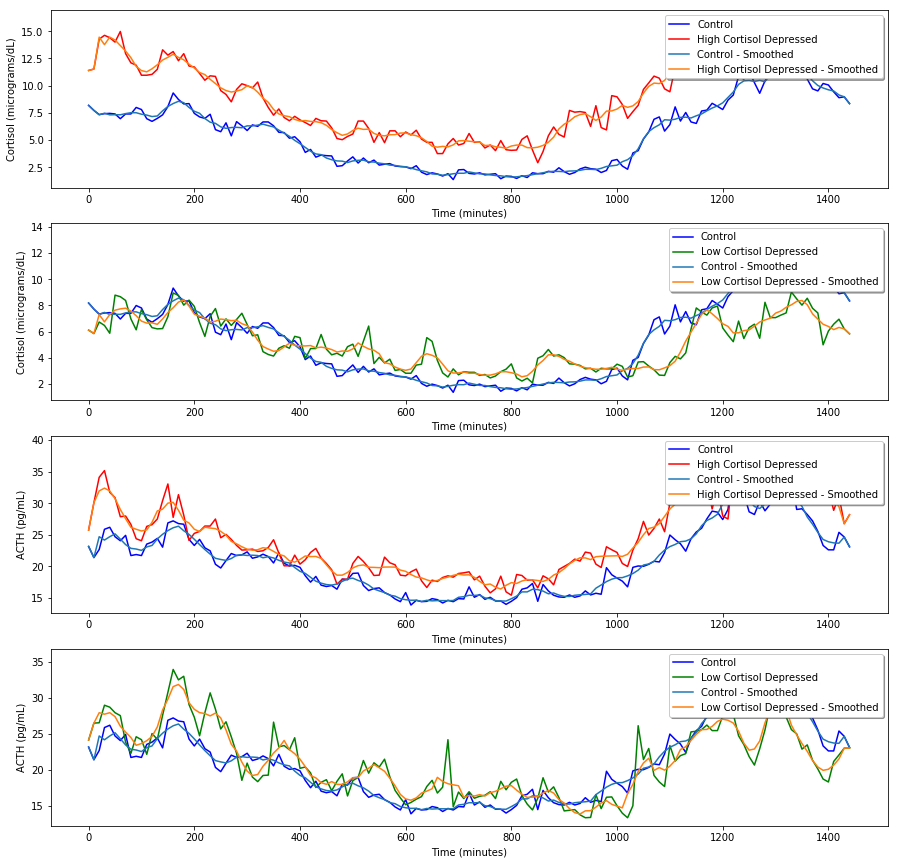

In [14]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

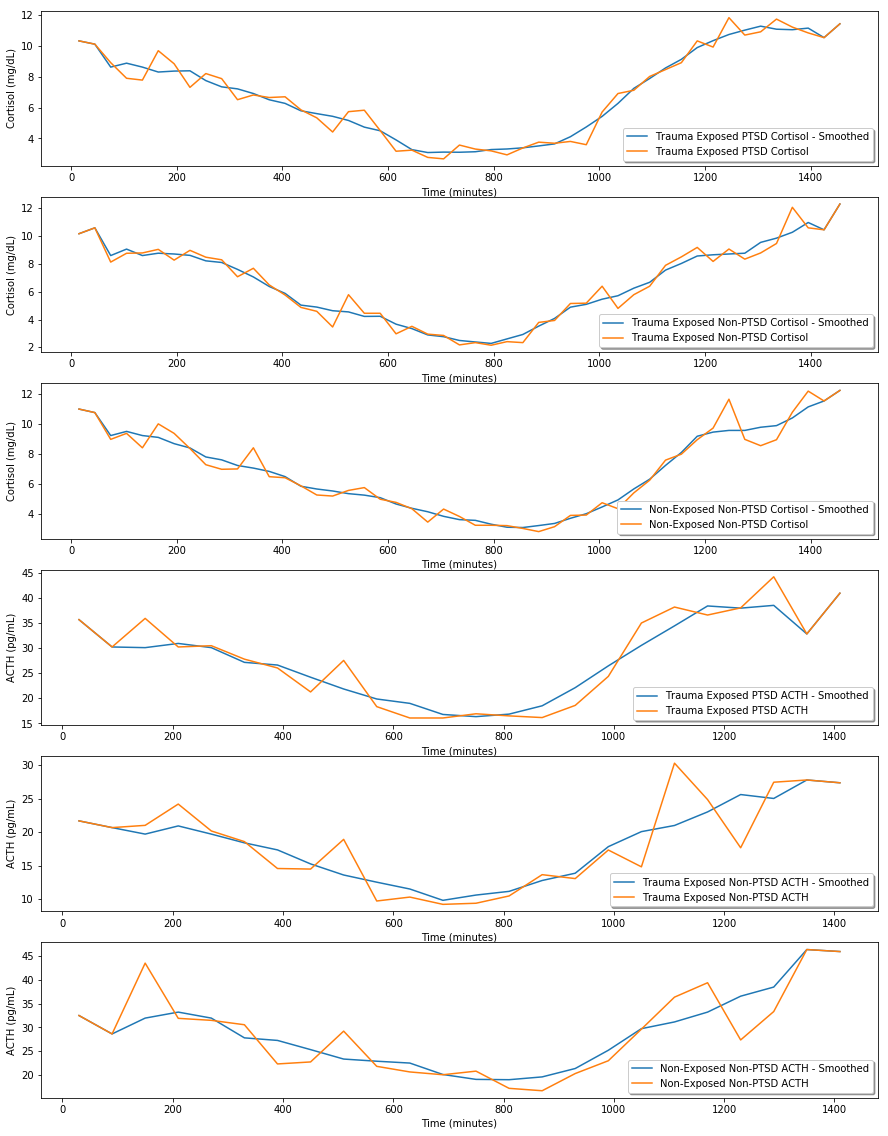

In [15]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (minutes)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


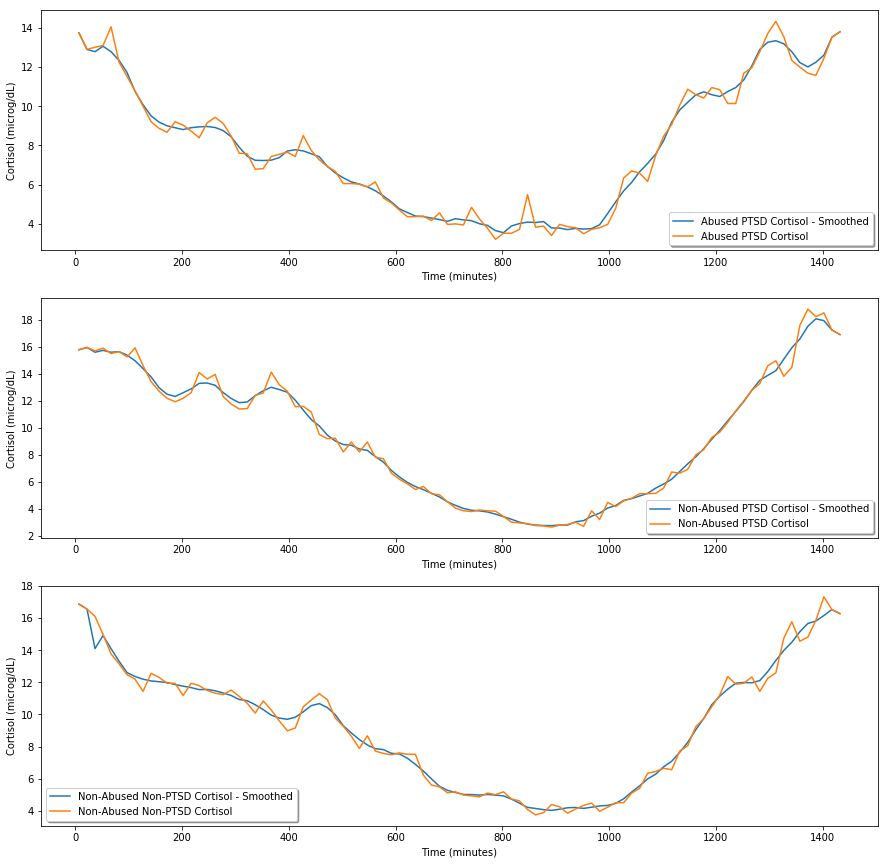

In [16]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (minutes)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


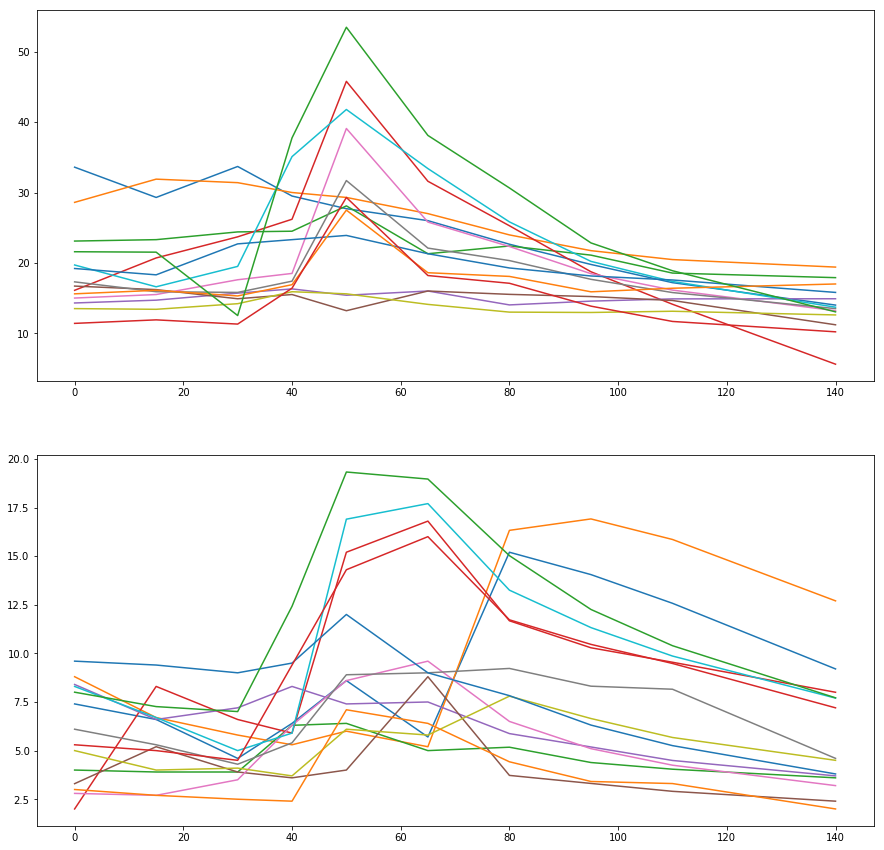

In [17]:
# graph the Nelson data (only showing one patient at a time currently)
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,0])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,2])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,3])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,4])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,5])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,6])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,7])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,8])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,9])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,10])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,11])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,12])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,13])

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,0])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,2])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,4])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,5])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,6])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,7])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,8])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,9])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,10])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,11])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,12])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,13])

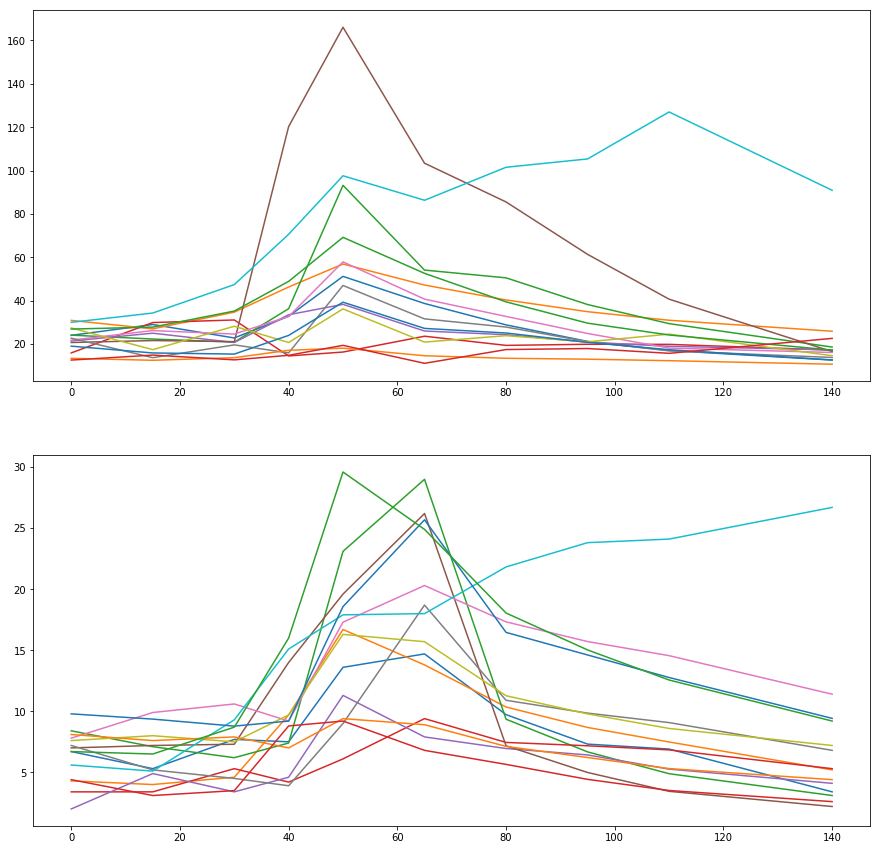

In [18]:
# graph the Nelson data (only showing one patient at a time currently)
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,0])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,2])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,3])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,4])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,5])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,6])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,7])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,8])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,9])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,10])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,11])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,12])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,13])

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,0])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,2])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,4])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,5])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,6])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,7])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,8])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,9])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,10])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,11])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,12])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCORT[:,13])

In [19]:
print(atypical_ids[0])

1.0


## Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [48]:
def model(params, ics):
    def ode_system(t, y):
        # The system has 6 equations for the 6 variables: CRH, ACTH, COR, GR, StreSig, kStr
        dy = np.zeros(6)
        
        # Unpack the array of parameters from the optimization algorithm
        [R0CRH, RCRH_CRH, RSS_CRH, RGR_CRH, tsCRH, R0ACTH, RCRH_ACTH, RGR_ACTH, tsACTH, R0COR, RACTH_COR, tsCOR, R0GR, RCOR_GR, RGR_GR, tsGR, d_0, d_1, d_2, d_3] = params
        
        dy[0] = tsCRH*FCRH(wCRH(y[0], y[4], y[3], R0CRH, RCRH_CRH, RSS_CRH, RGR_CRH)) - d_0*y[0]
        dy[1] = tsACTH*FACTH(wACTH(y[0], y[3], R0ACTH, RCRH_ACTH, RGR_ACTH)) - d_1*y[1]
        dy[2] = tsCOR*FCOR(wCOR(y[1], R0COR, RACTH_COR)) - d_2*y[2]
        dy[3] = tsGR*FGR(wGR(y[2], y[3], R0GR, RCOR_GR, RGR_GR)) - d_3*y[3]
        dy[4] = y[5]*y[4]
        
        if 30 < t < 40:
            dy[5] = 0.1
        elif 40 <= t < 50:
            dy[5] = -0.1
        else:
            dy[5] = 0
        
        return dy
    
    def wCRH(CRH, StreSig, GR, R0CRH, RCRH_CRH, RSS_CRH, RGR_CRH):
        # The variables in the function are (likely) the following:
        #     - R0CRH is the base rate of CRH production (not exactly this, as we take this function value and 
        #       plug into FCRH, but I think it's close)
        #     - RCRH_CRH is the rate at which CRH increases CRH production (I'm a bit unsure about this term, as 
        #       most models do not include positive feedback by CRH on itself)
        #     - RSS_CRH is the amount that 1 unit of stress increases CRH production
        #     - RGR_CRH is the rate at which GR increases CRH production (this is basically positive feedback by
        #       cortisol on CRH, which doesn't make sense)
        return R0CRH - RCRH_CRH*CRH + RSS_CRH*StreSig - RGR_CRH*GR
    
    def FCRH(wCRHv):
        # The variable in this function (sigma) determines how quickly the function trends to 1 as wCRH increases
        #
        # Note that the function starts at 0.5 for wCRH = 0
        # Also, note that sigma also determines how quickly FACTH and FCOR increase from 0.5 to 1
        return 1/(1 + np.exp(-sigma*wCRHv))
        
    def wACTH(CRH, GR, R0ACTH, RCRH_ACTH, RGR_ACTH):
        # The variables in the function are (likely) the following:
        #     - R0ACTH is the base rate of ACTH production (as with R0CRH, this isn't exactly the case, but I think
        #       it's close)
        #     - RCRH_ACTH is the rate of influence of CRH on ACTH production
        #     - RGR_ACTH is the rate of influence of GR on ACTH production (again, this seems to be positive feedback
        #       by cortisol, which doesn't track physiologically)
        return R0ACTH + RCRH_ACTH*CRH - RGR_ACTH*GR
    
    def FACTH(wACTHv):
        # The variable in this function (sigma) determines how quickly the function trends to 1 as wACTH increases
        #
        # Note that the function starts at 0.5 for wACTH = 0
        # Also, note that sigma also determines how quickly FCRH and FCOR increase from 0.5 to 1
        return 1/(1 + np.exp(-sigma*wACTHv))
    
    def wCOR(ACTH, R0COR, RACTH_COR):
        # The variables in the function are (likely) the following:
        #     - R0COR is the base rate of Cortisol production (as with R0CRH and R0ACTH, this isn't exactly the case,
        #       but I think it's close)
        #     - RACTH_COR is the rate at which ACTH influences Cortisol production
        return R0COR + RACTH_COR*ACTH
    
    def FCOR(wCORv):
        # The variable in this function (sigma) determines how quickly the function trends to 1 as wACTH increases
        #
        # Note that the function starts at 0.5 for wCOR = 0
        # Also, note that sigma also determines how quickly FCRH and FACTH increase from 0.5 to 1
        return 1/(1 + np.exp(-sigma*wCORv))
    
    def wGR(COR, GR, R0GR, RCOR_GR, RGR_GR):
        # The variables in the function are (likely) the following:
        #     - R0GR is the base rate of Glucocorticoid Receptor production (this isn't exactly the case, but I think
        #       it's close)
        #     - RCOR_GR is the rate at which Cortisol influences GR production
        #     - RGR_GR is the rate at which GR influences GR production (I'm not sure if GR actually upregulate GR
        #       production)
        return R0GR + RCOR_GR*COR + RGR_GR*GR
    
    def FGR(wGRv):
        # The variable in this function (sigma2) determines how quickly the function trends to 1 as wGR increases
        #
        # Note that the function starts at 0.5 for wGR = 0
        # This is the only F-function that uses sigma2, the others all depend on sigma
        return 1/(1 + np.exp(-sigma2*wGRv))
    
    timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end)
    return timeSeries

## Cost Function Definition <a name="cost"></a>

In [49]:
def cost_fun(params):
    simData = model(params, y0)
    
    # Call the cost() function in the costFun module
    # Note that we use nelsonACTH[:,0] and nelsonCortisol[:,0] for the time steps, because the subtype arrays don't
    #  have the time steps included
    return costFun.cost(params, nelsonACTH[:,0], nelsonAtypicalACTH[:,0], nelsonCortisol[:,0], nelsonAtypicalCORT[:,0], simData)


## Run the Optimization <a name="run"></a>

In [50]:
# Initial Conditions (I repeat the cell from above here for ease of running multiple optimizations with different ICs)
y0 = [1, nelsonAtypicalACTH[0,0], nelsonAtypicalCORT[0,0], 1, 0.1, 0]

In [51]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_crh = np.zeros((14002, n))
sims_acth = np.zeros((14002, n))
sims_cort = np.zeros((14002, n))
sims_gr = np.zeros((14002, n))
sims_streSig = np.zeros((14002, n))
sims_kStr = np.zeros((14002, n))

In [52]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_crh[:,i] = optimizedSimData[:,1]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_gr[:,i] = optimizedSimData[:,4]
    sims_streSig[:,i] = optimizedSimData[:,5]
    sims_kStr[:,i] = optimizedSimData[:,6]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 4.03505
differential_evolution step 2: f(x)= 2.07628
differential_evolution step 3: f(x)= 2.07628
differential_evolution step 4: f(x)= 2.07628
differential_evolution step 5: f(x)= 1.29416
differential_evolution step 6: f(x)= 1.29416
differential_evolution step 7: f(x)= 1.29416
differential_evolution step 8: f(x)= 1.29416
differential_evolution step 9: f(x)= 1.29416
differential_evolution step 10: f(x)= 1.07078
differential_evolution step 11: f(x)= 1.07078
differential_evolution step 12: f(x)= 1.06375
differential_evolution step 13: f(x)= 1.06317
differential_evolution step 14: f(x)= 1.06317
differential_evolution step 15: f(x)= 1.06317
differential_evolution step 16: f(x)= 1.06317
differential_evolution step 17: f(x)= 1.06317
differential_evolution step 18: f(x)= 1.06317
differential_evolution step 19: f(x)= 1.06317
differential_evolution step 20: f(x)= 1.05863
differential_evolution step 21: f(x)= 1.05764
differential_evolution 

/Users/christopher/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/Users/christopher/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


differential_evolution step 12: f(x)= 1.0638
differential_evolution step 13: f(x)= 1.0638
differential_evolution step 14: f(x)= 1.0638
differential_evolution step 15: f(x)= 1.0638
differential_evolution step 16: f(x)= 1.0638
differential_evolution step 17: f(x)= 1.0638
differential_evolution step 18: f(x)= 1.06369
differential_evolution step 19: f(x)= 1.06049
differential_evolution step 20: f(x)= 1.06049
differential_evolution step 21: f(x)= 1.06049
differential_evolution step 22: f(x)= 1.06049
differential_evolution step 23: f(x)= 1.06049
differential_evolution step 24: f(x)= 1.05833
differential_evolution step 25: f(x)= 1.05833
differential_evolution step 26: f(x)= 1.05809
differential_evolution step 27: f(x)= 1.05809
differential_evolution step 28: f(x)= 1.05776
differential_evolution step 29: f(x)= 1.05773
differential_evolution step 30: f(x)= 1.05773
Optimization Run #4
differential_evolution step 1: f(x)= 4.39073
differential_evolution step 2: f(x)= 1.64957
differential_evolution

## Save Output to File <a name="saveoutput"></a>

In [53]:
df_t = pd.DataFrame(optimizedSimData[:,0])
df_crh = pd.DataFrame(sims_crh)
df_acth = pd.DataFrame(sims_acth)
df_cort = pd.DataFrame(sims_cort)
df_gr = pd.DataFrame(sims_gr)
df_streSig = pd.DataFrame(sims_streSig)
df_kStr = pd.DataFrame(sims_kStr)

df_t.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-timeSteps-5-iterations-stressInput-point1.xlsx')
df_crh.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-crh-5-iterations-stressInput-point1.xlsx')
df_acth.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-acth-5-iterations-stressInput-point1.xlsx')
df_cort.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-cort-5-iterations-stressInput-point1.xlsx')
df_gr.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-gr-5-iterations-stressInput-point1.xlsx')
df_streSig.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-streSig-5-iterations-stressInput-point1.xlsx')
df_kStr.to_excel(excel_writer = 'individual-fitting-revised-atypical-patientID_1-sims-kStr-5-iterations-stressInput-point1.xlsx')

In [54]:
np.savetxt('individual-fitting-revised-atypical-patientID_1-opt-pars-5-iterations-stressInput-point1.txt', opt_pars)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-crh-5-iterations-stressInput-point1.txt', sims_crh)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-acth-5-iterations-stressInput-point1.txt', sims_acth)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-cort-5-iterations-stressInput-point1.txt', sims_cort)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-gr-5-iterations-stressInput-point1.txt', sims_gr)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-streSig-5-iterations-stressInput-point1.txt', sims_streSig)
np.savetxt('individual-fitting-revised-atypical-patientID_1-sims-kStr-5-iterations-stressInput-point1.txt', sims_kStr)
np.savetxt('individual-fitting-revised-atypical-patientID_1-y0-5-iterations-stressInput-point1.txt', y0)
np.savetxt('individual-fitting-revised-atypical-patientID_1-bounds-5-iterations-stressInput-point1.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [55]:
# compute parameter means and standard deviations
R0CRH_mean = np.mean(opt_pars[:,1])
R0CRH_std = np.std(opt_pars[:,1])
RCRH_CRH_mean = np.mean(opt_pars[:,2])
RCRH_CRH_std = np.std(opt_pars[:,2])
RSS_CRH_mean = np.mean(opt_pars[:,3])
RSS_CRH_std = np.std(opt_pars[:,3])
RGR_CRH_mean = np.mean(opt_pars[:,4])
RGR_CRH_std = np.std(opt_pars[:,4])
tsCRH_mean = np.mean(opt_pars[:,5])
tsCRH_std = np.std(opt_pars[:,5])
R0ACTH_mean = np.mean(opt_pars[:,6])
R0ACTH_std = np.std(opt_pars[:,6])
RCRH_ACTH_mean = np.mean(opt_pars[:,7])
RCRH_ACTH_std = np.std(opt_pars[:,7])
RGR_ACTH_mean = np.mean(opt_pars[:,8])
RGR_ACTH_std = np.std(opt_pars[:,8])
tsACTH_mean = np.mean(opt_pars[:,9])
tsACTH_std = np.std(opt_pars[:,9])
R0COR_mean = np.mean(opt_pars[:,10])
R0COR_std = np.std(opt_pars[:,10])
RACTH_COR_mean = np.mean(opt_pars[:,11])
RACTH_COR_std = np.std(opt_pars[:,11])
tsCOR_mean = np.mean(opt_pars[:,12])
tsCOR_std = np.std(opt_pars[:,12])
R0GR_mean = np.mean(opt_pars[:,13])
R0GR_std = np.std(opt_pars[:,13])
RCOR_GR_mean = np.mean(opt_pars[:,14])
RCOR_GR_std = np.std(opt_pars[:,14])
RGR_GR_mean = np.mean(opt_pars[:,15])
RGR_GR_std = np.std(opt_pars[:,15])
tsGR_mean = np.mean(opt_pars[:,16])
tsGR_std = np.std(opt_pars[:,16])

In [56]:
# print a table of parameter means and standard deviations
print(tabulate([["R0CRH", "%f +- %f" % (R0CRH_mean, R0CRH_std)], ["RCRH_CRH", "%f +- %f" % (RCRH_CRH_mean, RCRH_CRH_std)], ["RSS_CRH", "%f +- %f" % (RSS_CRH_mean, RSS_CRH_std)], ["RGR_CRH", "%f +- %f" % (RGR_CRH_mean, RGR_CRH_std)], ["tsCRH", "%f +- %f" % (tsCRH_mean, tsCRH_std)], ["R0ACTH", "%f +- %f" % (R0ACTH_mean, R0ACTH_std)], ["RCRH_ACTH", "%f +- %f" % (RCRH_ACTH_mean, RCRH_ACTH_std)], ["RGR_ACTH", "%f +- %f" % (RGR_ACTH_mean, RGR_ACTH_std)], ["tsACTH", "%f +- %f" % (tsACTH_mean, tsACTH_std)], ["R0COR", "%f +- %f" % (R0COR_mean, R0COR_std)], ["RACTH_COR", "%f +- %f" % (RACTH_COR_mean, RACTH_COR_std)], ["tsCOR", "%f +- %f" % (tsCOR_mean, tsCOR_std)], ["R0GR", "%f +- %f" % (R0GR_mean, R0GR_std)], ["RCOR_GR", "%f +- %f" % (RCOR_GR_mean, RCOR_GR_std)], ["RGR_GR", "%f +- %f" % (RGR_GR_mean, RGR_GR_std)], ["tsGR", "%f +- %f" % (tsGR_mean, tsGR_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))

Parameter    Mean +- Standard Deviation
-----------  ----------------------------
R0CRH        4.921352 +- 3.515242
RCRH_CRH     7.179215 +- 2.029043
RSS_CRH      6.005730 +- 1.950388
RGR_CRH      4.069078 +- 2.059232
tsCRH        4.459901 +- 2.571952
R0ACTH       7.486932 +- 1.638250
RCRH_ACTH    5.284939 +- 2.918410
RGR_ACTH     6.229842 +- 2.606879
tsACTH       6.329859 +- 3.716671
R0COR        5.794833 +- 1.905658
RACTH_COR    6.661768 +- 3.127454
tsCOR        9.491077 +- 0.463786
R0GR         5.463326 +- 3.202122
RCOR_GR      5.353775 +- 1.121635
RGR_GR       3.479986 +- 2.482697
tsGR         3.226638 +- 2.816848


In [57]:
np.savetxt('individual-fitting-revised-atypical-patientID_1-param-means-stds-5-iterations-stressInput-point1.txt', [R0CRH_mean, R0CRH_std, RCRH_CRH_mean, RCRH_CRH_std, RSS_CRH_mean, RSS_CRH_std, RGR_CRH_mean, RGR_CRH_std, tsCRH_mean, tsCRH_std, R0ACTH_mean, R0ACTH_std, RCRH_ACTH_mean, RCRH_ACTH_std, RGR_ACTH_mean, RGR_ACTH_std, tsACTH_mean, tsACTH_std, R0COR_mean, R0COR_std, RACTH_COR_mean, RACTH_COR_std, tsCOR_mean, tsCOR_std, R0GR_mean, R0GR_std, RCOR_GR_mean, RCOR_GR_std, RGR_GR_mean, RGR_GR_std, tsGR_mean, tsGR_std])

## Plots <a name="plots"></a>

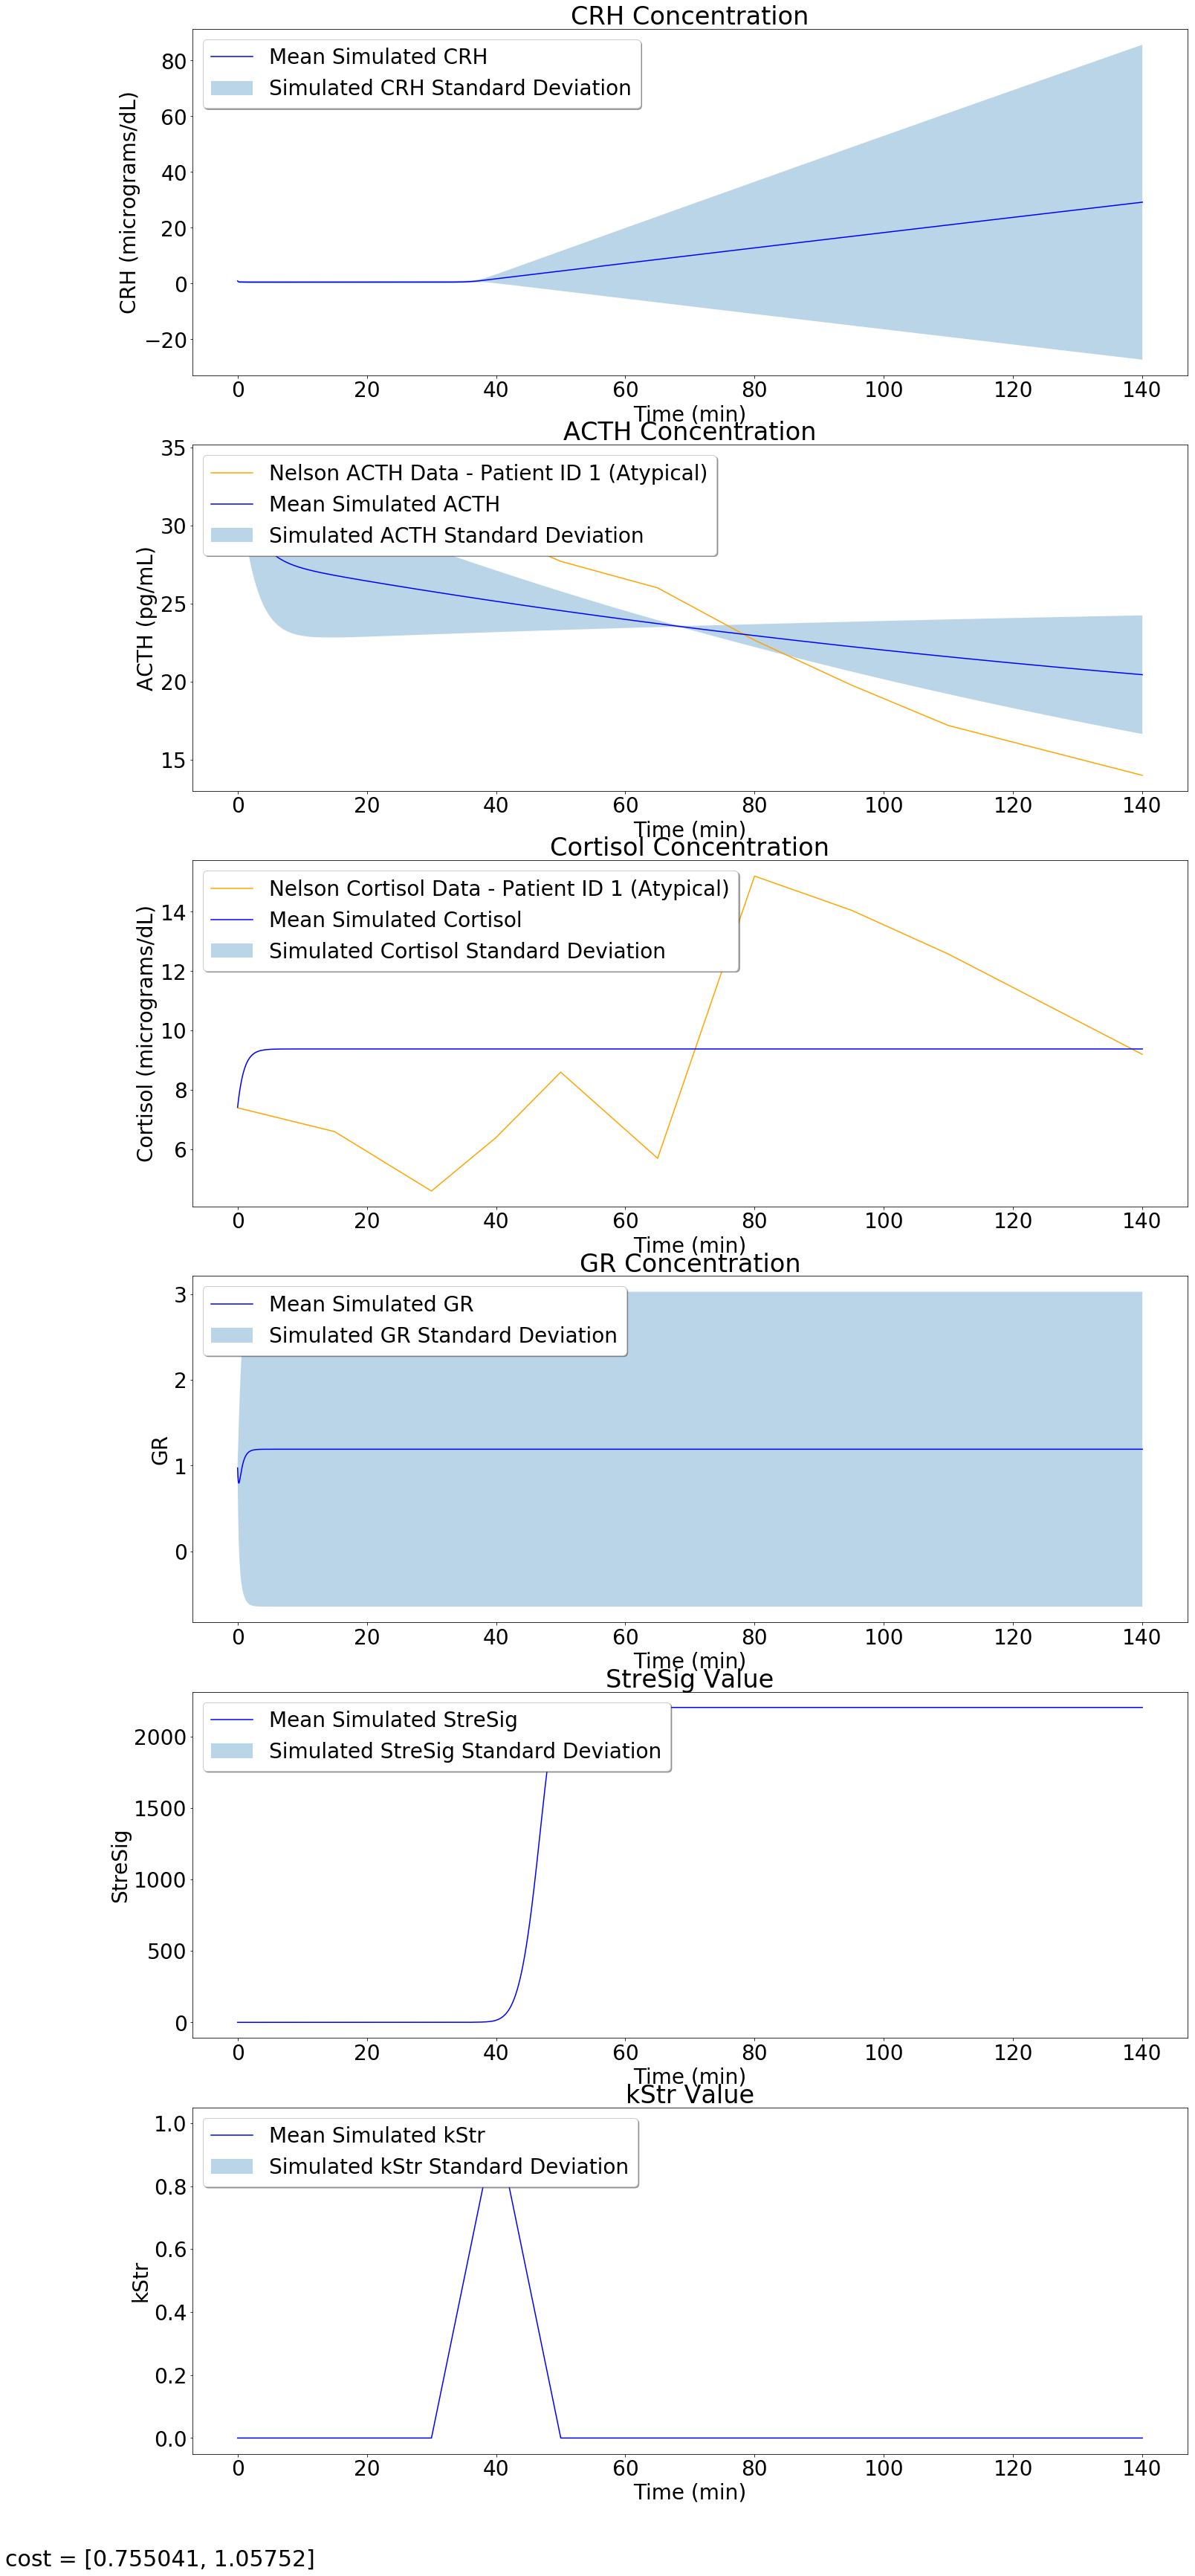

In [59]:
%matplotlib inline
matplotlib.rc('font', **{'size'   : 28})

# plot with 6 subfigures--CRH, ACTH, Cortisol, GR, StreSig and kStr
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (24, 60))

# if running more than one iteration of optimization, uncomment plot command with np.mean and fill_between
# and comment plot command without np.mean
#
# if only one run is stored in sims variables, comment out plot commands with np.mean and fill_between
#ax1.plot(optimizedSimData[:,0], sims_crh, label = "Simulated CRH Data", color = "blue")
ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Mean Simulated CRH", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (min)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

ax2.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,0], label = "Nelson ACTH Data - Patient ID 1 (Atypical)", color = "orange")
#ax2.plot(optimizedSimData[:,0], sims_acth, label = "Simulated ACTH Data", color = "blue")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Mean Simulated ACTH", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (min)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax3.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,0], label = "Nelson Cortisol Data - Patient ID 1 (Atypical)", color = "orange")
#ax3.plot(optimizedSimData[:,0], sims_cort, label = "Simulated Cortisol Data", color = "blue")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Mean Simulated Cortisol", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (min)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#ax4.plot(optimizedSimData[:,0], sims_gr, label = "Simulated GR Data", color = "blue")
ax4.plot(optimizedSimData[:,0], np.mean(sims_gr, axis = 1), label = "Mean Simulated GR", color = "blue")
ax4.fill_between(optimizedSimData[:,0], np.mean(sims_gr, axis = 1) - np.std(sims_gr, axis = 1), np.mean(sims_gr, axis = 1) + np.std(sims_gr, axis = 1), alpha = 0.3, label = "Simulated GR Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (min)", ylabel = "GR", title = "GR Concentration")

#ax5.plot(optimizedSimData[:,0], sims_streSig, label = "Simulated StreSig Data", color = "blue")
ax5.plot(optimizedSimData[:,0], np.mean(sims_streSig, axis = 1), label = "Mean Simulated StreSig", color = "blue")
ax5.fill_between(optimizedSimData[:,0], np.mean(sims_streSig, axis = 1) - np.std(sims_streSig, axis = 1), np.mean(sims_streSig, axis = 1) + np.std(sims_streSig, axis = 1), alpha = 0.3, label = "Simulated StreSig Standard Deviation")
ax5.legend(loc = "upper left", shadow = True, fancybox = True)
ax5.set(xlabel = "Time (min)", ylabel = "StreSig", title = "StreSig Value")

#ax6.plot(optimizedSimData[:,0], sims_kStr, label = "Simulated kStr Data", color = "blue")
ax6.plot(optimizedSimData[:,0], np.mean(sims_kStr, axis = 1), label = "Mean Simulated kStr", color = "blue")
ax6.fill_between(optimizedSimData[:,0], np.mean(sims_kStr, axis = 1) - np.std(sims_kStr, axis = 1), np.mean(sims_kStr, axis = 1) + np.std(sims_kStr, axis = 1), alpha = 0.3, label = "Simulated kStr Standard Deviation")
ax6.legend(loc = "upper left", shadow = True, fancybox = True)
ax6.set(xlabel = "Time (min)", ylabel = "kStr", title = "kStr Value")

# include the value of the cost function for this set of graphs at the bottom of the figure
txt = "cost = [0.755041, 1.05752]"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 30)
plt.savefig("individual-fitting-revised-atypical-patientID_1-5-iterations-stressInput-point1.png", dpi = 300)

## No Optimization Run and Plot <a name = "no-opt"></a>

In [24]:
# Set initial conditions to use for simulation without parameter optimization
y0 = [1, nelsonAtypicalACTH[0,0], nelsonAtypicalCORT[0,0], 1, 0.1, 0]

In [25]:
# Define the time interval over which to integrate
t_start = -0.01
t_end = 140.01
t_step = 0.01

In [78]:
# Define parameter values to use for simulation without parameter optimization

R0CRH = 1
RCRH_CRH = 1
RSS_CRH = 1
RGR_CRH = 1
tsCRH = 1
R0ACTH = 1
RCRH_ACTH = 1
RGR_ACTH = 1
tsACTH = 1
R0COR = 1
RACTH_COR = 1
tsCOR = 1
R0GR = 1
RCOR_GR = 1
RGR_GR = 1
tsGR = 1

sigma = 5
sigma2 = 1

noOptParams = [R0CRH, RCRH_CRH, RSS_CRH, RGR_CRH, tsCRH, R0ACTH, RCRH_ACTH, RGR_ACTH, tsACTH, R0COR, RACTH_COR, tsCOR, R0GR, RCOR_GR, RGR_GR, tsGR]

In [79]:
%%time

noOptSimData = model(noOptParams, y0)

sims_crh = noOptSimData[:,1]
sims_acth = noOptSimData[:,2]
sims_cort = noOptSimData[:,3]
sims_gr = noOptSimData[:,4]
sims_streSig = noOptSimData[:,5]
sims_kStr = noOptSimData[:,6]

CPU times: user 132 ms, sys: 11.5 ms, total: 143 ms
Wall time: 136 ms


[Text(0, 0.5, 'kStr'),
 Text(0.5, 0, 'Time (min)'),
 Text(0.5, 1.0, 'kStr Value')]

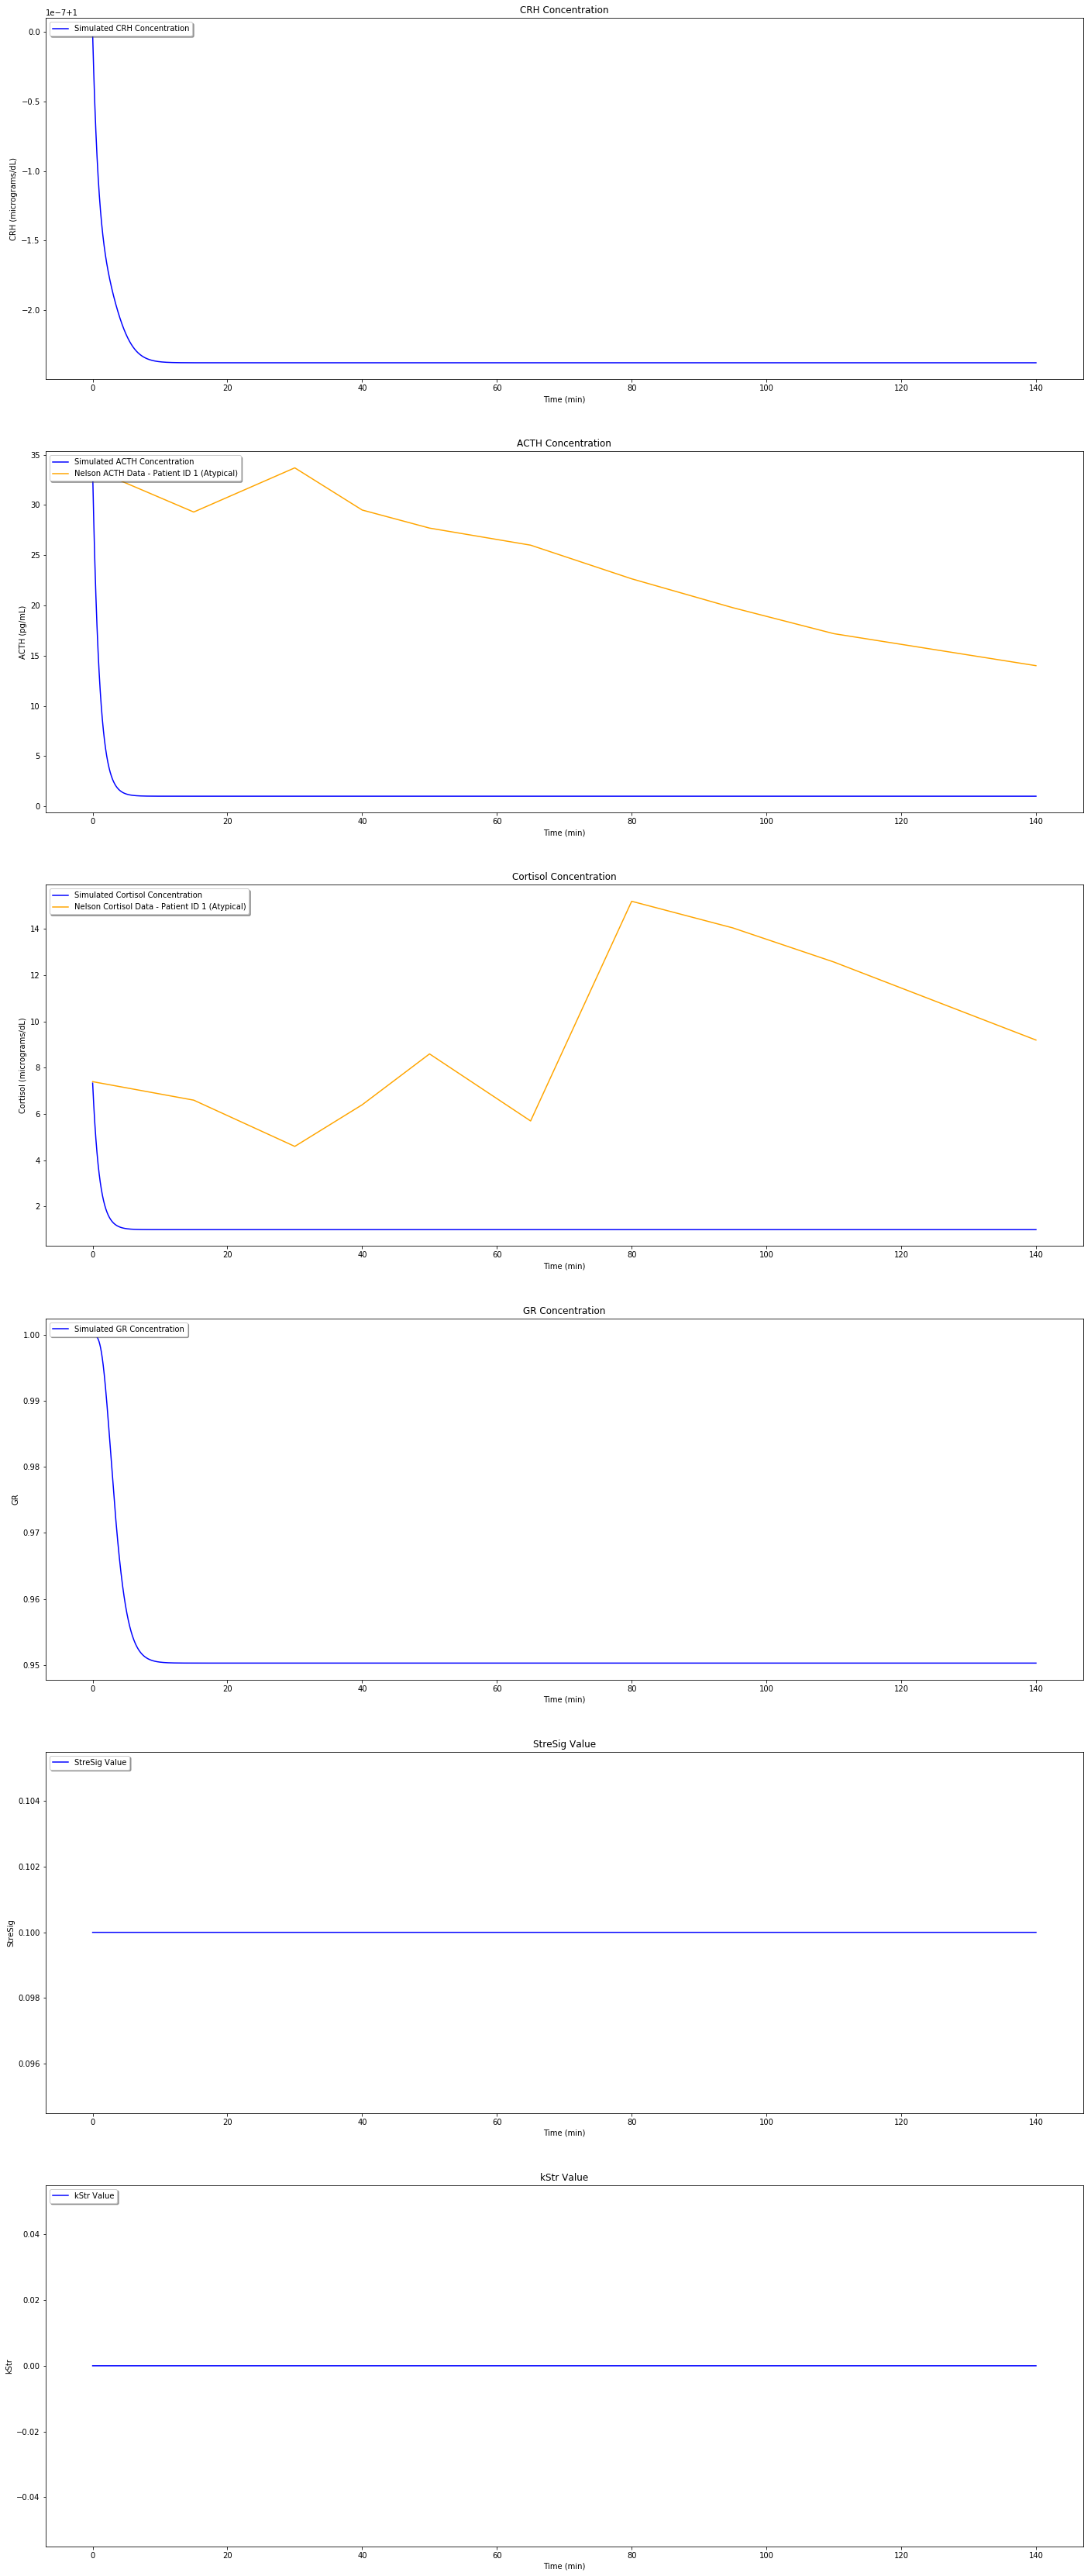

In [80]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (24, 60))

ax1.plot(noOptSimData[:,0], sims_crh, label = "Simulated CRH Concentration", color = "blue")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (min)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

ax2.plot(noOptSimData[:,0], sims_acth, label = "Simulated ACTH Concentration", color = "blue")
ax2.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,0], label = "Nelson ACTH Data - Patient ID 1 (Atypical)", color = "orange")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (min)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax3.plot(noOptSimData[:,0], sims_cort, label = "Simulated Cortisol Concentration", color = "blue")
ax3.plot(nelsonCortisol[:,0], nelsonAtypicalCORT[:,0], label = "Nelson Cortisol Data - Patient ID 1 (Atypical)", color = "orange")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (min)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

ax4.plot(noOptSimData[:,0], sims_gr, label = "Simulated GR Concentration", color = "blue")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (min)", ylabel = "GR", title = "GR Concentration")

ax5.plot(noOptSimData[:,0], sims_streSig, label = "StreSig Value", color = "blue")
ax5.legend(loc = "upper left", shadow = True, fancybox = True)
ax5.set(xlabel = "Time (min)", ylabel = "StreSig", title = "StreSig Value")

ax6.plot(noOptSimData[:,0], sims_kStr, label = "kStr Value", color = "blue")
ax6.legend(loc = "upper left", shadow = True, fancybox = True)
ax6.set(xlabel = "Time (min)", ylabel = "kStr", title = "kStr Value")

#plt.savefig("individual-fitting-atypical-patientID_1-no_opt-testing_RCRH_CRH-100.png")

## Dependencies <a name="dependencies"></a>

In [24]:
%load_ext watermark
%watermark --iversions

pandas    : 0.23.4
mpld3     : 0.3.1.dev1
scipy     : 1.1.0
numpy     : 1.21.5
matplotlib: 3.0.1

